# Project 2: Valuation of JPMorgan Chase Financial Company LLC Trigger Autocallable Contingent Yield Notes


In [ ]:
!pip install pandas_market_calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.0/198.0 kB 10.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
from datetime import datetime
import pandas_market_calendars as mcal
import scipy.stats as si
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime
from scipy.interpolate import interp1d

In [ ]:
def build_stock_price_tree(S0, T, sigma, N):
    """ Construct a binomial stock price tree (ignoring dividends). """
    dt = T / N  # Time step
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor

    # Initialize tree
    stock_tree = np.zeros((N+1, N+1))
    stock_tree[0, 0] = S0

    # Fill stock price tree
    for i in range(1, N+1):
        for j in range(i+1):
            # At each node, price = S0 * u^(number of ups) * d^(number of downs)
            number_of_ups = j
            number_of_downs = i - j
            stock_tree[i,j] = S0 * (u**number_of_ups) * (d**number_of_downs)


    return stock_tree, u, d, dt

In [ ]:
def build_valuation_tree(S0,stock_tree, K, T, r_expanded, N, obs_steps, u, d, issue_price, coupon, coupon_steps, div):
    """ Construct valuation tree considering discrete dividends. """
    dt = T / N  # Time step
    option_tree = np.zeros((N+1, N+1))
    cont_value = 0

    # Get last observation step and last coupon step
    last_obs_step = obs_steps[-1]
    last_coupon_step = coupon_steps[-1]  # This is maturity date

    if last_obs_step >= len(r_expanded):
        last_obs_step = len(r_expanded) - 1

    # Time between last observation and coupon payment
    time_to_payment = (last_coupon_step - last_obs_step) * dt

    # Discount factor for final payment
    discount_factor = np.exp(-r_expanded[last_obs_step] * time_to_payment)


    # Payoff at valuation date
    for i in range(N+1):
        if stock_tree[N, i] >= 0.65*S0:
            # Discount both issue_price and coupon from maturity to last observation
            discounted_payment = (issue_price + coupon) * discount_factor
            option_tree[N, i] = discounted_payment

        else:
            # Discount the loss amount from maturity to last observation
            loss_amount = issue_price * (1 + (stock_tree[N,i] - S0)/S0)
            discounted_loss = loss_amount * discount_factor
            option_tree[N, i] = discounted_loss



    # Backward induction
    for i in range(N-1, -1, -1):
        discount = np.exp(-r_expanded[i] * dt)
        q = (np.exp((r_expanded[i] - div)* dt) - d) / (u - d)

        for j in range(i+1):
            # Calculate pure continuation value
            cont_value = discount * (q * option_tree[i+1,j+1] + (1-q) * option_tree[i+1,j])
            option_tree[i,j] = cont_value  # Set initial value

            # Check observation dates
            if i in obs_steps:

                if stock_tree[i,j] >= S0: # checking for Autocallability
                  # Find the next coupon payment date after this observation
                  next_coupon_step = None
                  for cs in coupon_steps:
                    if cs > i:
                      next_coupon_step = cs
                      break

                  if next_coupon_step is not None:
                    # Calculate time to next coupon payment
                    time_to_payment = (next_coupon_step - i) * dt
                    # Discount factor from next coupon date to current observation date
                    discount_factor = np.exp(-r_expanded[i] * time_to_payment)

                    # Discount both issue_price and coupon
                    discounted_payment = (issue_price + coupon) * discount_factor
                    option_tree[i,j] = discounted_payment

                  else:
                    # If no future coupon date (last observation), no discounting needed
                    option_tree[i,j] = issue_price + coupon


                elif stock_tree[i,j] >= K: # checking for hitting coupon barrier
                  # Find next coupon payment step for this observation
                  next_coupon_step = None
                  for cs in coupon_steps:
                      if cs > i:
                          next_coupon_step = cs
                          break

                  if next_coupon_step is not None:
                      # Discount only the coupon from payment date to observation
                      time_to_payment = (next_coupon_step - i) * dt
                      discount_factor = np.exp(-r_expanded[i] * time_to_payment)
                      discounted_coupon = coupon * discount_factor
                      option_tree[i,j] = cont_value + discounted_coupon

                  else:
                    option_tree[i,j] = cont_value + coupon

                else:
                  option_tree[i,j] = cont_value  # Below barrier, no coupon



    #i = 5
    #print(f"\nOption prices at step {i}:")
    #for j in range(i+1):
      #print(f"O[{i},{j}] = {option_tree[i,j]:.2f}")

    return option_tree

In [ ]:
# Calculate trading days
nyse = mcal.get_calendar('NYSE')

# Get trading days between dates
def get_trading_days(start_date, end_date):
    trading_days = nyse.valid_days(start_date=start_date, end_date=end_date)
    return len(trading_days)

In [ ]:
# Define trade date
trade_date = np.datetime64('2025-01-24')
settlement_date = np.datetime64('2025-01-29')
final_valuation_date = np.datetime64('2026-01-23')
maturity_date = np.datetime64('2026-01-28')

coupon_payment_dates = np.array([
    '2025-04-28', '2025-07-28', '2025-10-28', '2026-01-28'
], dtype='datetime64[D]')

observation_actual_dates = np.array([
    '2025-04-23', '2025-07-23', '2025-10-23', '2026-01-23'
], dtype='datetime64[D]')

# Available discount factors and their corresponding dates from Bloomberg
bbg_dates = np.array([
    '2025-03-28', '2025-04-28',
    '2025-06-30', '2025-07-28',
    '2025-07-31', '2025-10-28',
    '2025-10-31', '2026-01-28'
], dtype='datetime64[D]')

bbg_discount_factors = np.array([
    0.992472, 0.988839,
    0.981626, 0.978515,
    0.978732, 0.968533,
    0.968799, 0.958863
])

# # calculate number of trading days
N = get_trading_days(trade_date, final_valuation_date)
print ("Number of trading days: ", N, "\n")

# # Parameters
S0 = 190.70  # Initial stock price
K = 123.96   # Coupon barrier
T = (final_valuation_date - trade_date).astype(float) / 365    # Time to maturity in years
sigma = 0.37797  # Volatility
dt = T/N # Time steps
div = 0.02071 # continuous dividend yield


# # Instrument parameters
issue_price = 10.0  # Issue price
coupon = 0.2838  # Contingent Coupon in $

# Convert dates to years from trade date
bbg_times = (bbg_dates - trade_date).astype(float) / 365
obs_times = (observation_actual_dates - trade_date).astype(float) / 365

# Interpolate discount factors for observation dates
interp_func = interp1d(bbg_times, bbg_discount_factors, kind='linear', fill_value='extrapolate')
discount_factors = interp_func(obs_times)

# Compute spot rates
spot_rates = -np.log(discount_factors) / obs_times

# Compute forward rates
forward_rates = np.zeros(4)  # Ensure r_array has exactly 4 values
forward_rates[0] = spot_rates[0]  # First forward rate is the same as the first spot rate
for i in range(1, 4):  # Compute remaining forward rates
    t1, t2 = obs_times[i-1], obs_times[i]
    r1, r2 = spot_rates[i-1], spot_rates[i]
    forward_rates[i] = (t2 * r2 - t1 * r1) / (t2 - t1)

# Convert to numpy array
r_array = forward_rates

# print("Updated Observation Times (Years):", obs_times)
print("Updated Spot Rates:", spot_rates)
print("Updated Forward Rates (r_array):", r_array)

# Define observation dates in time steps
obs_steps = np.ceil(np.array(obs_times) * N / T).astype(int)
r_expanded = np.zeros(N)  # Initialize the expanded rate array

# Expanding the risk-free rate for each time step
for i in range(len(r_array)):
    if i == 0:
        r_expanded[:obs_steps[0]] = r_array[0]
    else:
        r_expanded[obs_steps[i-1]:obs_steps[i]] = r_array[i]
    if i == len(r_array) - 1:
        r_expanded[obs_steps[i]:] = r_array[i]

# Define coupon-related parameters
issue_price = 10.0  # Issue price
coupon = 0.2838  # Contingent Coupon in $

# Convert to years from trade date
coupon_dates = (coupon_payment_dates - trade_date).astype(float) / 365
coupon_steps = np.ceil(np.array(coupon_dates) * N / T).astype(int)  # Convert to step indices

# Build stock price tree (no dividends considered)
stock_tree, u, d, dt = build_stock_price_tree(S0, T, sigma, N)

# Build valuation tree (dividends handled here)
option_tree = build_valuation_tree(S0, stock_tree, K, T, r_expanded, N,
                                   obs_steps, u, d,
                                   issue_price, coupon, coupon_steps, div)

# Option price at root node
print(f"Option Price: {option_tree[0, 0]:.4f}")


Number of trading days:  251 

Updated Spot Rates: [0.04360046 0.04289072 0.04211094 0.0415389 ]
Updated Forward Rates (r_array): [0.04360046 0.04219659 0.04058528 0.03984763]
Option Price: 9.7446


## Sensitivity Analysis

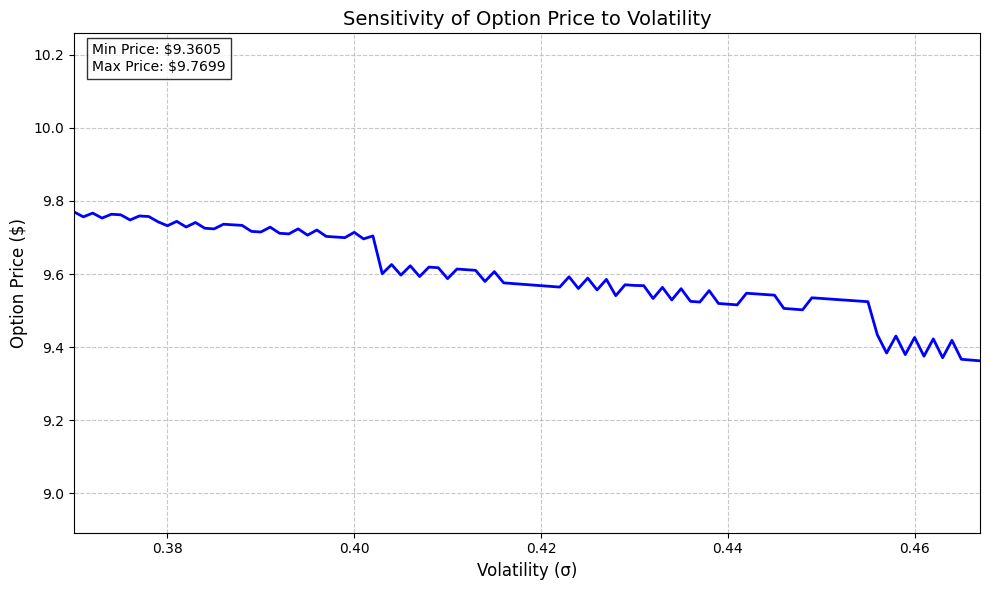

In [ ]:
# Sensitivity based on volatility
# Create range of sigma values
sigma_start = 0.37
sigma_end = 0.467
step = 0.001
sigma_range = np.arange(sigma_start, sigma_end + step, step)

# Lists to store results
option_prices = []

# Calculate option prices for each sigma
for sigma in sigma_range:
    stock_tree, u, d, dt = build_stock_price_tree(S0, T, sigma, N)
    option_tree = build_valuation_tree(S0, stock_tree, K, T, r_expanded, N,
                                     obs_steps, u, d, issue_price, coupon,
                                     coupon_steps, div)
    option_prices.append(option_tree[0, 0])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(sigma_range, option_prices, 'b-', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.7)

# Add labels and title
plt.xlabel('Volatility (σ)', fontsize=12)
plt.ylabel('Option Price ($)', fontsize=12)
plt.title('Sensitivity of Option Price to Volatility', fontsize=14)

# Format axes
plt.xlim(sigma_start, sigma_end)
plt.ylim(min(option_prices)*0.95, max(option_prices)*1.05)

# Add text box with key statistics
stats_text = f'Min Price: ${min(option_prices):.4f}\nMax Price: ${max(option_prices):.4f}'
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

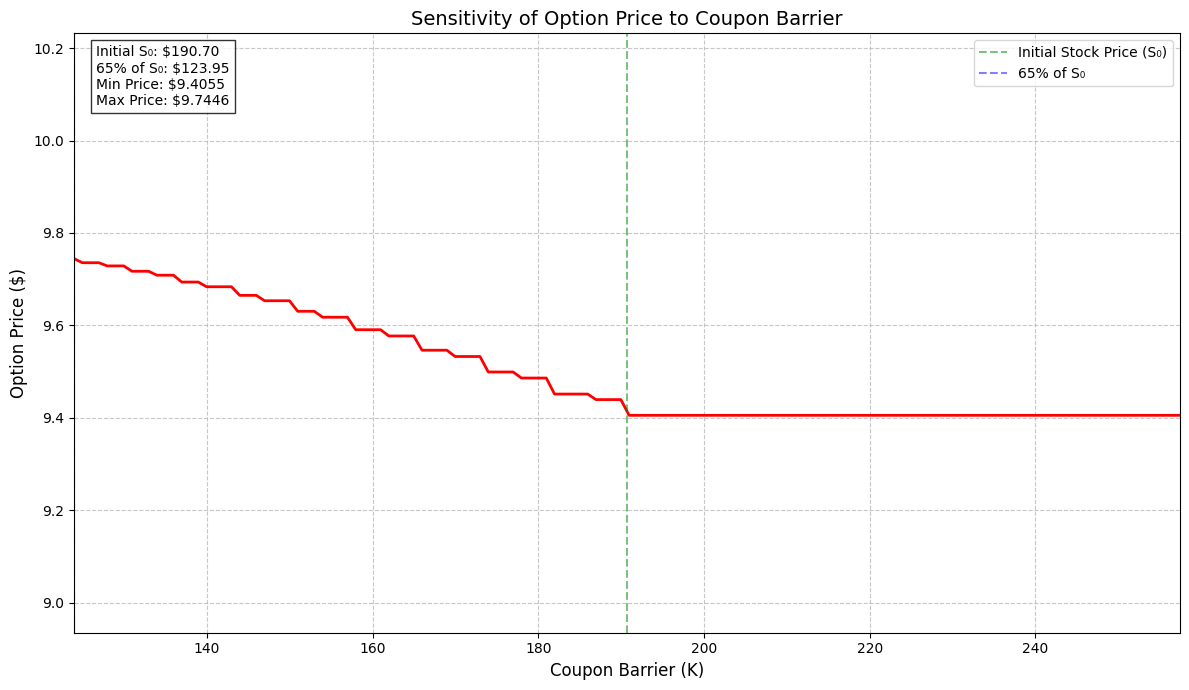

In [ ]:
# Sensitivity based on Coupon barrier

# Create range of K values
K_start = 123.96  # 65% of S0
K_end = 257.45    # 135% of S0
step = 1        # smaller step for smoother plot
K_range = np.arange(K_start, K_end + step, step)
sigma = 0.37797  # Volatility

# Lists to store results
option_prices = []

# Calculate option prices for each K
for barrier in K_range:
    stock_tree, u, d, dt = build_stock_price_tree(S0, T, sigma, N)
    option_tree = build_valuation_tree(S0, stock_tree, barrier, T, r_expanded, N,
                                     obs_steps, u, d, issue_price, coupon,
                                     coupon_steps, div)
    option_prices.append(option_tree[0, 0])

# Create the plot
plt.figure(figsize=(12, 7))
plt.plot(K_range, option_prices, 'r-', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.7)

# Add labels and title
plt.xlabel('Coupon Barrier (K)', fontsize=12)
plt.ylabel('Option Price ($)', fontsize=12)
plt.title('Sensitivity of Option Price to Coupon Barrier', fontsize=14)

# Format axes
plt.xlim(K_start, K_end)
plt.ylim(min(option_prices)*0.95, max(option_prices)*1.05)

# Add vertical lines for reference points
plt.axvline(x=S0, color='g', linestyle='--', alpha=0.5, label='Initial Stock Price (S₀)')
plt.axvline(x=0.65*S0, color='b', linestyle='--', alpha=0.5, label='65% of S₀')

# Add text box with key statistics
stats_text = (f'Initial S₀: ${S0:.2f}\n'
             f'65% of S₀: ${0.65*S0:.2f}\n'
             f'Min Price: ${min(option_prices):.4f}\n'
             f'Max Price: ${max(option_prices):.4f}')
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.legend()
plt.tight_layout()
plt.show()



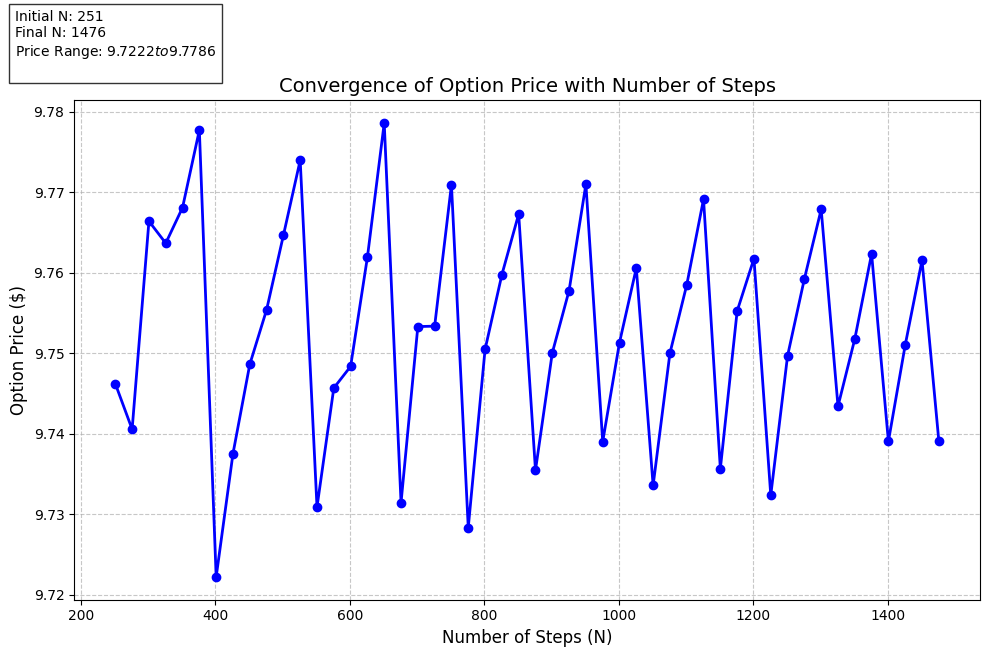

In [ ]:
# Sensitivity based on number of steps

# Create range of N values
N_range = np.arange(251, 1501, 25)
K = 123.96

# Lists to store results
option_prices = []
computation_times = []  # To track performance

from time import time

# Calculate option prices for each N
for steps in N_range:
    start_time = time()

    stock_tree, u, d, dt = build_stock_price_tree(S0, T, sigma, steps)

    # Adjust observation and coupon steps for new N
    obs_steps_adj = np.ceil(np.array(obs_times) * steps / T).astype(int)
    coupon_steps_adj = np.floor(np.array(coupon_dates) * steps / T).astype(int)

    # Expand rates for new N
    r_expanded_adj = np.zeros(steps)
    for i in range(len(r_array)):
        if i == 0:
            r_expanded_adj[:obs_steps_adj[0]] = r_array[0]
        else:
            r_expanded_adj[obs_steps_adj[i-1]:obs_steps_adj[i]] = r_array[i]
        if i == len(r_array) - 1:
            r_expanded_adj[obs_steps_adj[i]:] = r_array[i]

    option_tree = build_valuation_tree(S0, stock_tree, K, T, r_expanded_adj, steps,
                                     obs_steps_adj, u, d, issue_price, coupon,
                                     coupon_steps_adj, div)

    end_time = time()

    option_prices.append(option_tree[0, 0])
    computation_times.append(end_time - start_time)

# Create two subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))

# Plot: Option Price vs Number of Steps
ax1.plot(N_range, option_prices, 'b-', linewidth=2, marker='o')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xlabel('Number of Steps (N)', fontsize=12)
ax1.set_ylabel('Option Price ($)', fontsize=12)
ax1.set_title('Convergence of Option Price with Number of Steps', fontsize=14)


# Add text box with key statistics
stats_text = (f'Initial N: {N_range[0]}\n'
             f'Final N: {N_range[-1]}\n'
             f'Price Range: ${min(option_prices):.4f} to ${max(option_prices):.4f}\n'
             )
plt.figtext(0.02, 0.98, stats_text, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()